In [1]:
# Importing libraries

# Analysis
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#----model and support imports----
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

# Feature Engineering
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# Deployment
from flask import Flask, render_template, request
import pickle

# Set the default style for plotting
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

#### Basic EDA

In [2]:
marketing = pd.read_csv('data/marketing_marketing.csv')
marketing.head()

,lead_id,lead_need,lead_owner,lead_budget,lead_source,lead_industry,lead_location,lead_authority,lead_companysize,lead_last_contacted,lead_conversion_history,lead_score,Converted,lead_interactions,lead_behavior_score,lead_engagemen_tscore,lead_conversion_outcome,lead_conversion_attempts
0,1,Standard,AE9,High,Inbound,Healthcare,EMEA,Recommender,Mid-Market,2022-08-15,Failed,65,1,14,72,70,0,2
1,1,Standard,AE 8,Medium,Inbound,Finance,EMEA,Decision Maker,Enterprise,2023-07-15,Successful,70,1,12,57,68,1,1
2,1,Urgent,AE 8,High,Inbound,Technology,EMEA,Decision Maker,Enterprise,2022-01-01,Failed,75,1,13,69,72,0,2
3,1,Critical,AE 3,Low,Drift,Healthcare,AMER,Recommender,Mid-Market,2022-04-01,Successful,39,0,15,75,75,1,3
4,1,Standard,AE 4,Medium,Inbound,Finance,EMEA,Influencer,Small Business,2023-01-15,Successful,66,1,9,58,70,1,1


In [3]:
marketing.columns = marketing.columns.str.lower().str.replace('lead_', '')
marketing.columns

Index(['id', 'need', 'owner', 'budget', 'source', 'industry', 'location',
       'authority', 'companysize', 'last_contacted', 'conversion_history',
       'score', 'converted', 'interactions', 'behavior_score',
       'engagemen_tscore', 'conversion_outcome', 'conversion_attempts'],
      dtype='object')

In [4]:
X = marketing.drop(['id','converted'], axis=1)
y = marketing['converted']

In [5]:
# Generate an initial report using ydataprofiling
#profile = ProfileReport(marketing,title="Marketing Marketing")
# Save the report to .html
#profile.to_file("Marketing Marketing.html")

In [16]:
X.head(5)

,need,owner,budget,source,industry,location,authority,companysize,last_contacted,conversion_history,score,interactions,behavior_score,engagemen_tscore,conversion_outcome,conversion_attempts
0,Standard,AE9,High,Inbound,Healthcare,EMEA,Recommender,Mid-Market,2022-08-15,Failed,65,14,72,70,0,2
1,Standard,AE 8,Medium,Inbound,Finance,EMEA,Decision Maker,Enterprise,2023-07-15,Successful,70,12,57,68,1,1
2,Urgent,AE 8,High,Inbound,Technology,EMEA,Decision Maker,Enterprise,2022-01-01,Failed,75,13,69,72,0,2
3,Critical,AE 3,Low,Drift,Healthcare,AMER,Recommender,Mid-Market,2022-04-01,Successful,39,15,75,75,1,3
4,Standard,AE 4,Medium,Inbound,Finance,EMEA,Influencer,Small Business,2023-01-15,Successful,66,9,58,70,1,1


In [ ]:
#### Hypothesis 1: higher engagement score = higher chance of conversion

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   need                 13200 non-null  object
 1   owner                13200 non-null  object
 2   budget               13200 non-null  object
 3   source               13200 non-null  object
 4   industry             13200 non-null  object
 5   location             13200 non-null  object
 6   authority            13200 non-null  object
 7   companysize          13200 non-null  object
 8   last_contacted       13200 non-null  object
 9   conversion_history   13200 non-null  object
 10  score                13200 non-null  int64 
 11  interactions         13200 non-null  int64 
 12  behavior_score       13200 non-null  int64 
 13  engagemen_tscore     13200 non-null  int64 
 14  conversion_outcome   13200 non-null  int64 
 15  conversion_attempts  13200 non-null  int64 
dtypes: i

In [7]:
unique_values = {}
for column in X.columns:
    unique_values[column] = X[column].unique()
    
print(unique_values)

{'need': array(['Standard', 'Urgent', 'Critical'], dtype=object), 'owner': array(['AE9', 'AE 8', 'AE 3', 'AE 4', 'AE 7', 'AE 11', 'AE 5', 'AE 6',
       'AE 2', 'AE 1', 'AE 10'], dtype=object), 'budget': array(['High', 'Medium', 'Low'], dtype=object), 'source': array(['Inbound', 'Drift', 'Employee Referral', 'Outbound',
       'Customer Referral', 'Partner Referral'], dtype=object), 'industry': array(['Healthcare', 'Finance', 'Technology', 'Retail'], dtype=object), 'location': array(['EMEA', 'AMER', 'Other', 'APAC'], dtype=object), 'authority': array(['Recommender', 'Decision Maker', 'Influencer'], dtype=object), 'companysize': array(['Mid-Market', 'Enterprise', 'Small Business'], dtype=object), 'last_contacted': array(['2022-08-15', '2023-07-15', '2022-01-01', '2022-04-01',
       '2023-01-15', '2022-06-15', '2022-08-01', '2022-02-01',
       '2022-03-01', '2022-05-15', '2022-12-15', '2022-05-01',
       '2023-03-15', '2023-06-15', '2022-01-15', '2023-02-01',
       '2022-02-15', '202

#### Data Visualisation

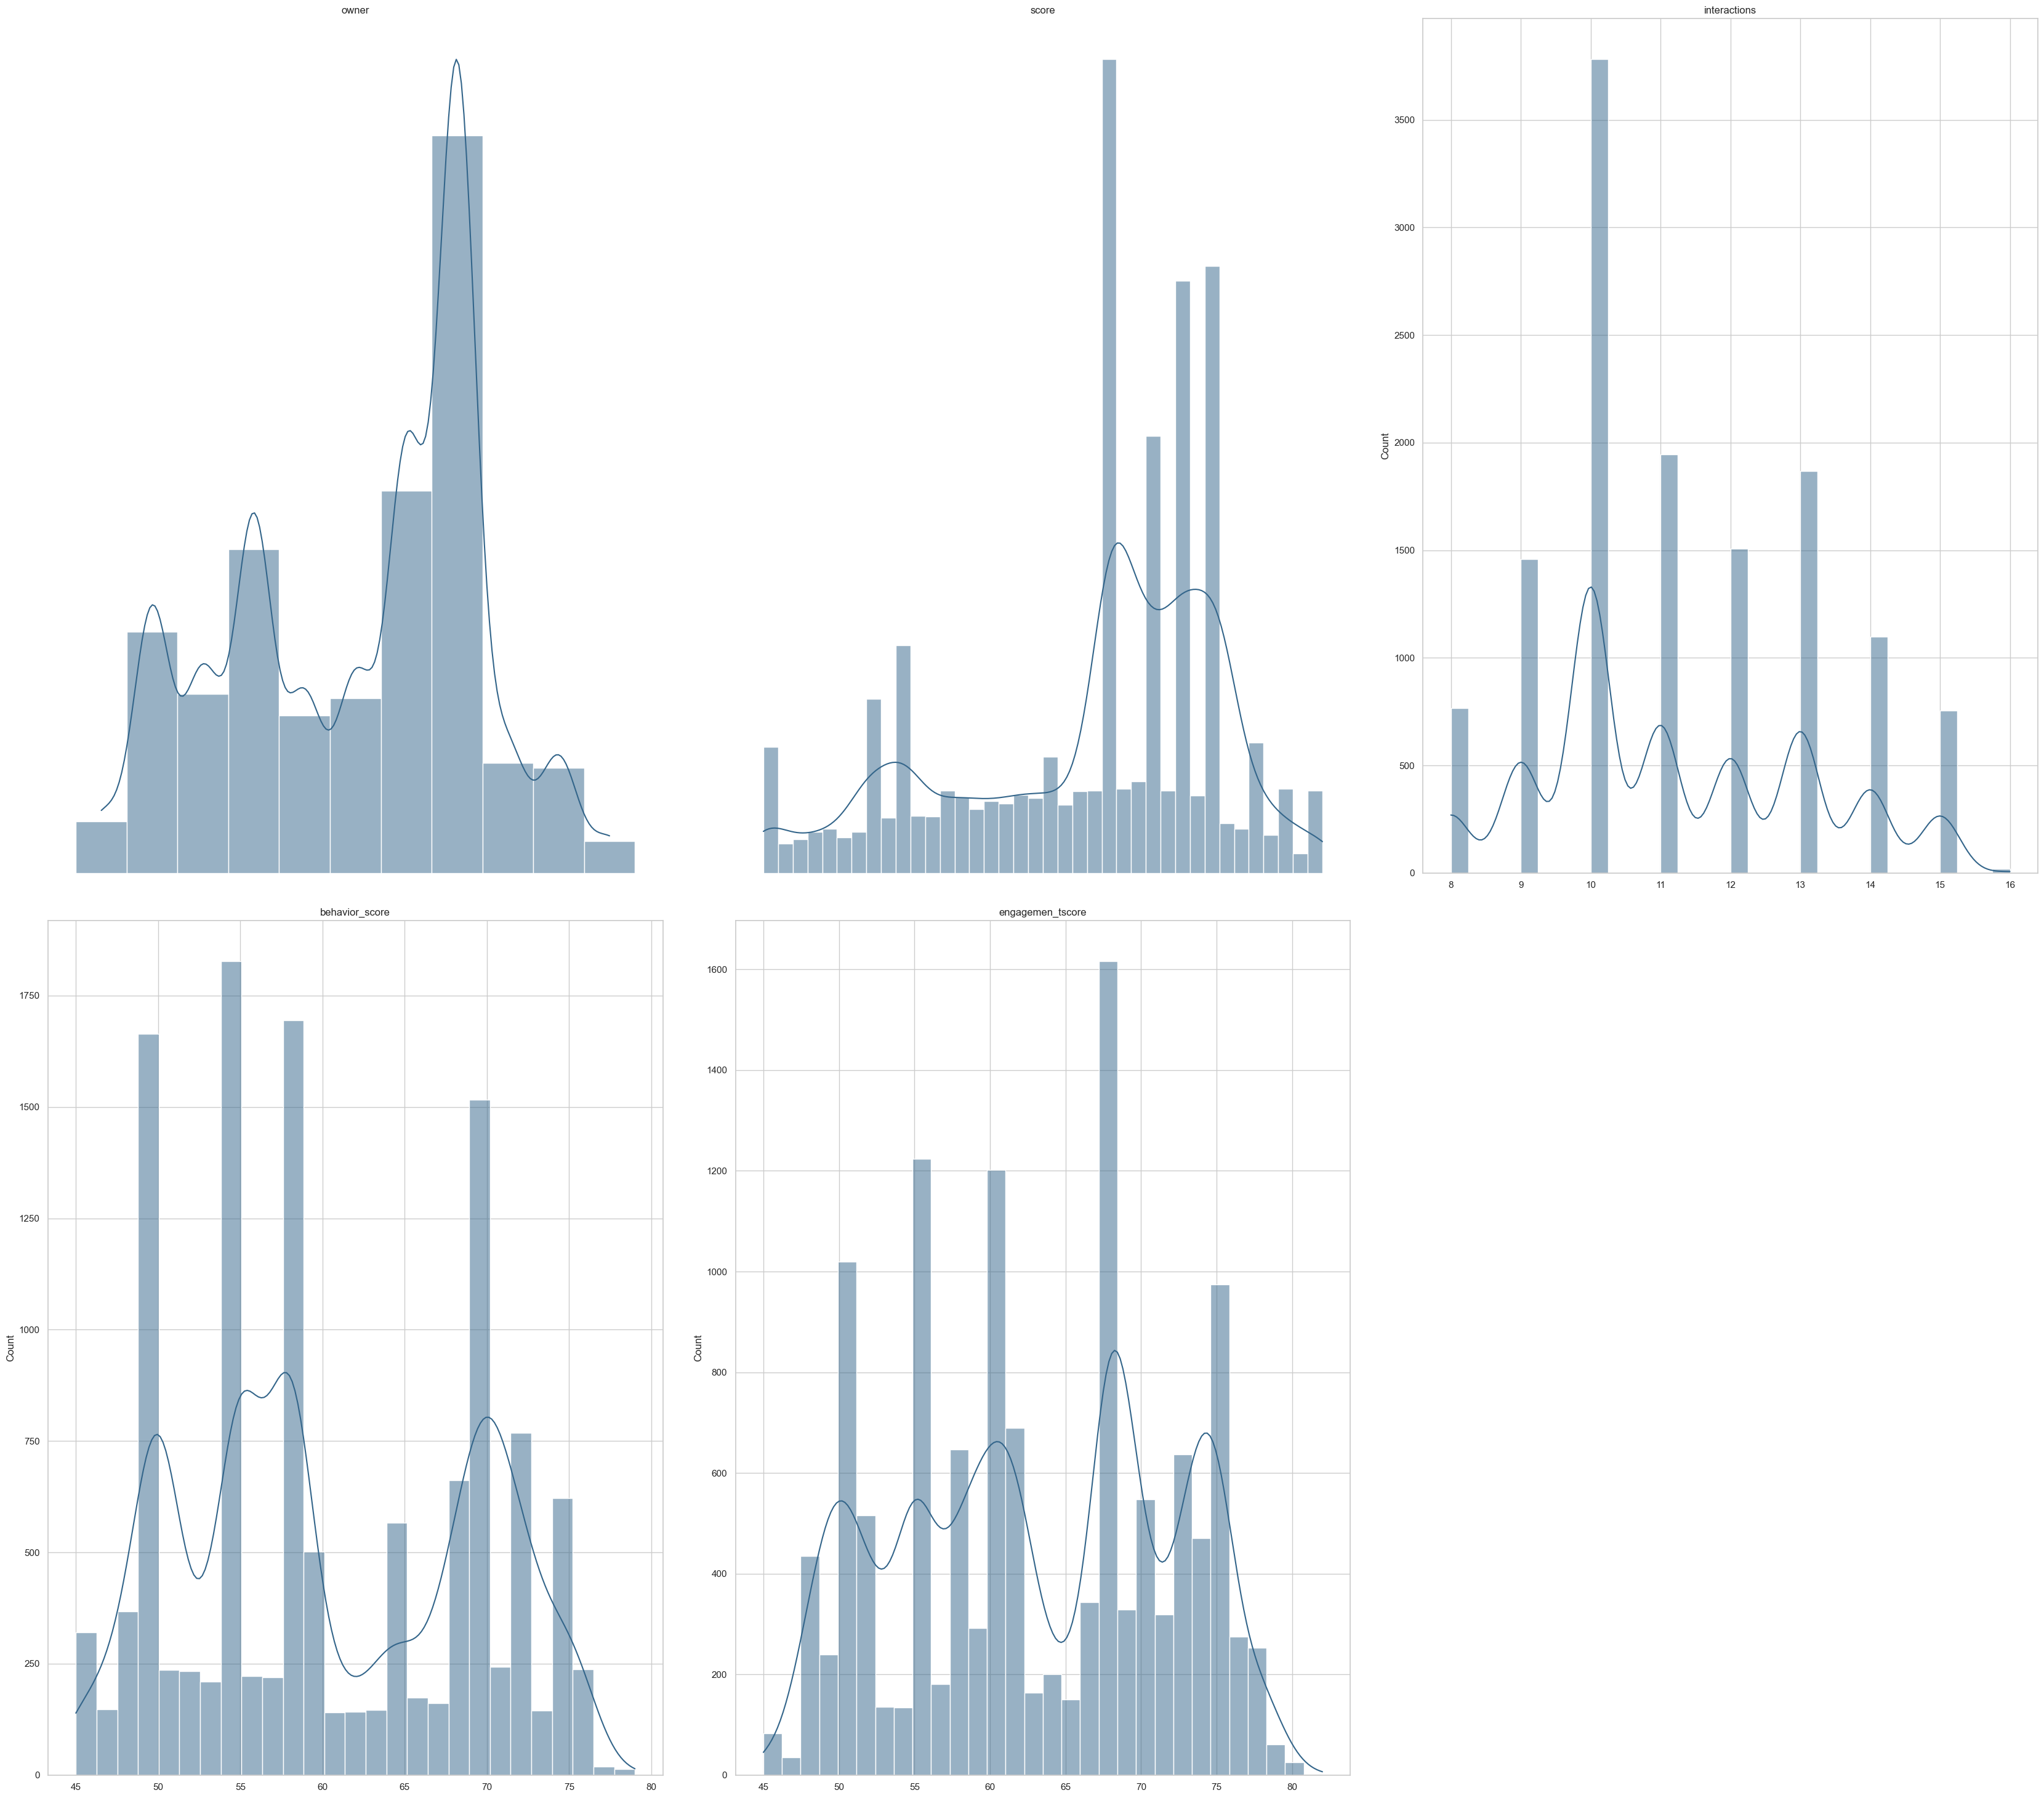

In [14]:
include_col = ['owner', 'score', 'interactions', 'behavior_score', 'engagemen_tscore']

# Plot distribution of features, excluding specified columns
fig, ax = plt.subplots(2, 3, figsize=(34, 30))
count = 0
for item in X:
    if item in include_col:
        sns.histplot(X[item], kde=True, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
        count += 1
    else:
        ax[int(count/3)][count%3].axis('off')  # Exclude the subplot for excluded columns

fig.tight_layout(pad=3)
plt.show()

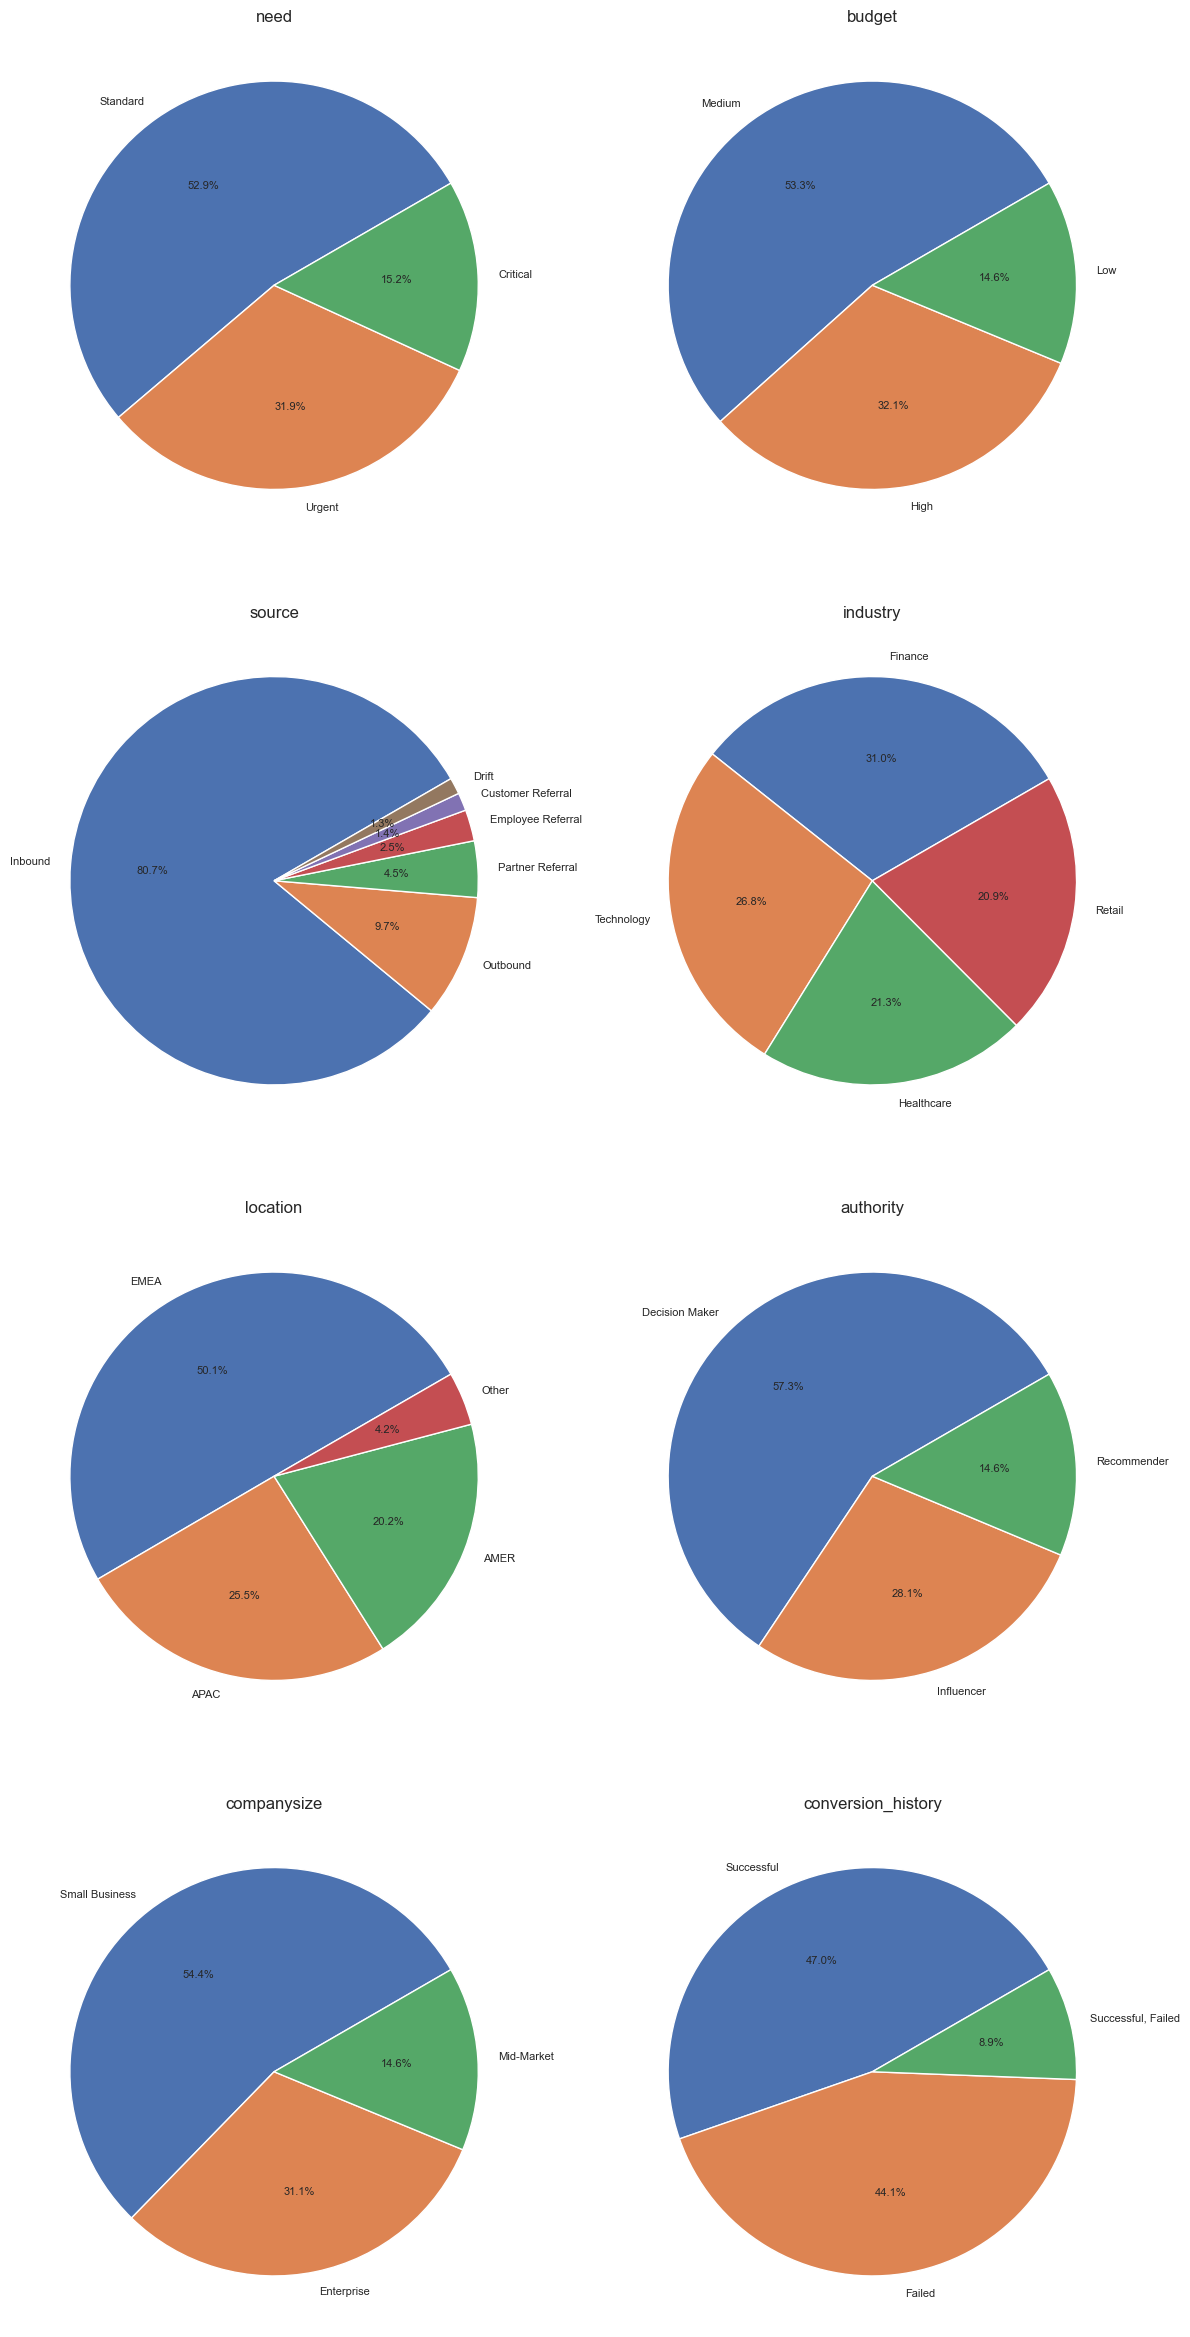

In [11]:
# Identify categorical columns
cat_col = X.select_dtypes(include=['object']).columns

# Columns to exclude from pie chart
exclude_col = ['owner', 'last_contacted']

# Filter included columns
included_col = [col for col in cat_col if col not in exclude_col]

# Check if there are included columns
if not included_col:
    print("No included columns after exclusion.")
else:
    # Calculate the number of rows needed for 2 pie charts per row
    num_rows = int(np.ceil(len(included_col) / 2))

    # Set up subplots with 2 columns
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 6))

    # Flatten the axes array to simplify indexing
    axes = axes.flatten()

    # Plot pie charts for each included categorical feature
    for i, column in enumerate(included_col):
        # Calculate counts for each category
        counts = X[column].value_counts()

        # Plot pie chart
        axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%',
                    startangle=30, labeldistance=1.1, textprops={'fontsize': 8})

        axes[i].set_title(column)

    # Hide empty subplots, if any
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

        
    plt.tight_layout()
    plt.show()


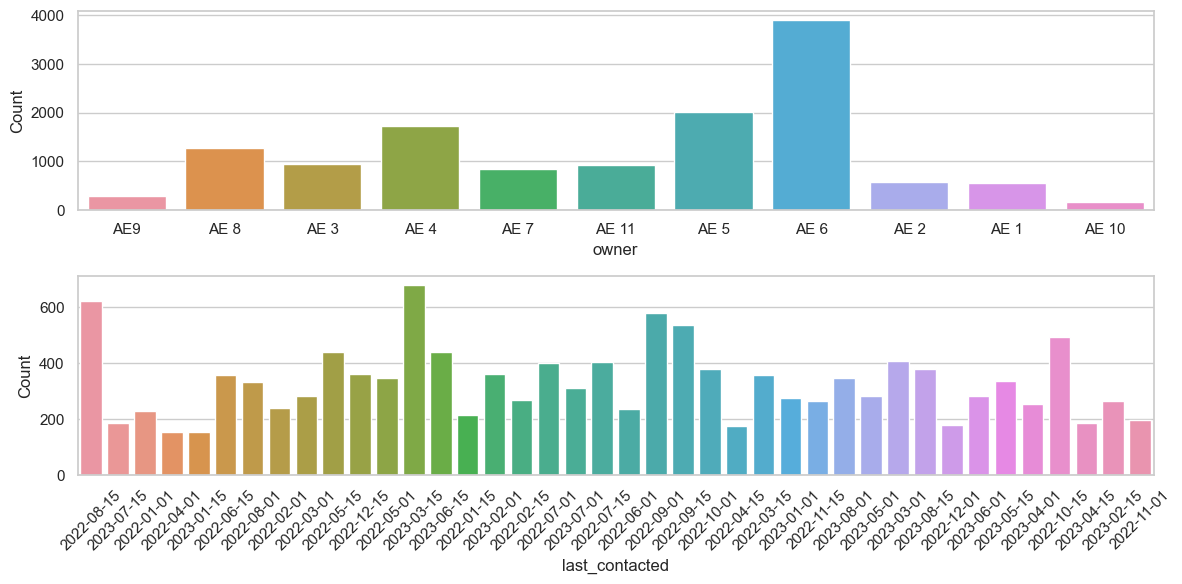

In [15]:
# Set up subplots
fig, axes = plt.subplots(len(exclude_col), 1, figsize=(12, len(exclude_col) * 3))

# Plot count plots for the excluded categorical feature
for i, column in enumerate(exclude_col):
    sns.countplot(x=column, data=X, ax=axes[i])
    #axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()